Alpha est estimé à -8.145969229488722e-06 avec un écart-type de 0.000995219598520221
Beta est estimé à 1.6402271987088925e-05 avec un écart-type de 0.0009996992197217301
Gamma est estimé à -2.1318987965135236e-06 avec un écart-type de 0.0009942882360436736
Sigma est estimé à 0.2659706040306326 avec un écart-type de 0.2711402241953147


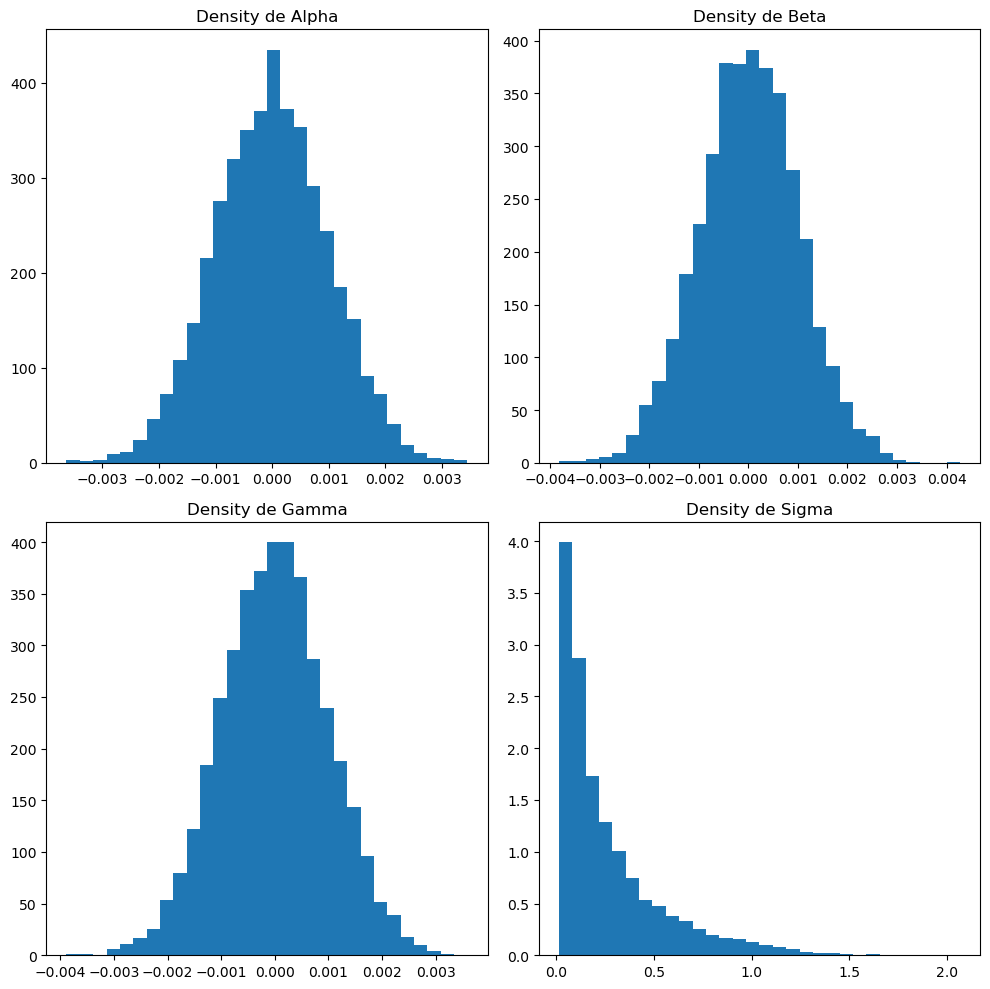

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, poisson

# Récupération des données
Ndoses = 6
Nplates = 3
y = np.array([[15, 16, 16],
              [27, 33, 20],
              [21, 18, 26],
              [41, 38, 27],
              [29, 21, 33],
              [60, 41, 42]])
x = np.array([0, 10, 33, 100, 333, 1000])

# Initialisation
alpha_star = 0
beta = 0
gamma = 0
tau = 0.1
lambda_ = np.random.normal(0, np.sqrt(1/tau), (6, 3))

# Implémentation de la méthode MCMC (Hastings within Gibbs)
def model(y, x, nchain, alpha, beta, gamma, tau, lambda_):
    n = len(x)
    m = y.shape[1]
    res = np.zeros((nchain, 4))
    for k in range(nchain):
        for i in range(n):
            for j in range(m):
                mu_ij = np.exp(alpha + beta * np.log(x[i] + 10) + gamma * x[i] + lambda_[i, j])
                lambda_[i, j] = np.random.normal(0, np.sqrt(1/tau))
                y[i, j] = np.random.poisson(mu_ij)
        alpha = np.random.normal(alpha_star, np.sqrt(1/1e6))
        beta = np.random.normal(0, np.sqrt(1/1e6))
        gamma = np.random.normal(0, np.sqrt(1/1e6))
        tau = np.random.gamma(0.001 + 9 * n * m, 0.001 + 0.5 * np.sum(lambda_**2))
        res[k] = [alpha, beta, gamma, 1/np.sqrt(tau)]
    return res

results = model(y, x, 10000, alpha_star, beta, gamma, tau, lambda_)

# Récupération des résultats
burn_in = 1000
results_post_burn_in = results[burn_in:, :]
moychain = np.mean(results_post_burn_in, axis=0) # moyenne
sdchain = np.std(results_post_burn_in, axis=0) # écart type

print("Alpha est estimé à", moychain[0], "avec un écart-type de", sdchain[0])
print("Beta est estimé à", moychain[1], "avec un écart-type de", sdchain[1])
print("Gamma est estimé à", moychain[2], "avec un écart-type de", sdchain[2])
print("Sigma est estimé à", moychain[3], "avec un écart-type de", sdchain[3])

# Visualisation des résultats
plt.figure(figsize=(10, 10))

# Allure des densités pour Alpha, Beta, Gamma et Sigma
plt.subplot(2, 2, 1)
plt.title("Density de Alpha")
plt.hist(results_post_burn_in[:, 0], bins=30, density=True)
plt.subplot(2, 2, 2)
plt.title("Density de Beta")
plt.hist(results_post_burn_in[:, 1], bins=30, density=True)
plt.subplot(2, 2, 3)
plt.title("Density de Gamma")
plt.hist(results_post_burn_in[:, 2], bins=30, density=True)
plt.subplot(2, 2, 4)
plt.title("Density de Sigma")
plt.hist(results_post_burn_in[:, 3], bins=30, density=True)

plt.tight_layout()
plt.show()


In [2]:
mean = [moychain[0], moychain[1], moychain[2], moychain[3]]
sd = [sdchain[0], sdchain[1], sdchain[2], sdchain[3]]

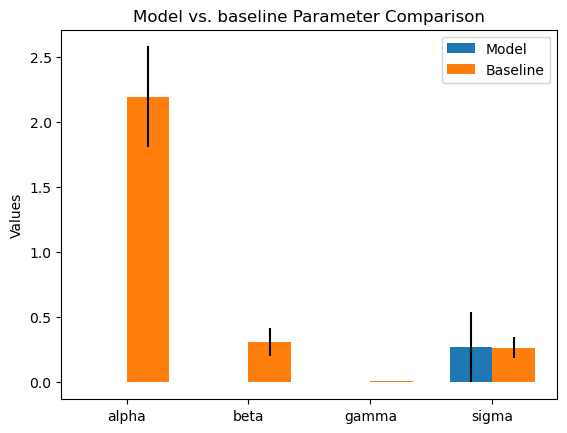

In [4]:
#Baseline here indicates Breslow and Clayton estimates
def plot_parameter_comparison(params_df):
    ind = np.arange(len(params_df))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width / 2, params_df['mean'], width, label='Model', yerr=params_df['std'])
    rects2 = ax.bar(ind + width / 2, params_df['mean_base'], width, label='Baseline', yerr=params_df['std_base'])

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_ylabel('Values')
    ax.set_title('Model vs. baseline Parameter Comparison')
    ax.set_xticks(ind)
    ax.set_xticklabels(['alpha', 'beta', 'gamma', 'sigma'])
    ax.legend()

    plt.show()

#results_summary = results.describe().T
import pandas as pd
params_df = pd.DataFrame()
params_df['mean'] = mean
params_df['std'] = sd
#Breslow and Clayton estimates
params_df['mean_base'] = [2.193, 0.3059, 69.577*(10**(-4)), 0.2608]
params_df['std_base'] = [0.3874, 0.1054, 4.525*(10**(-4)), 0.08077]
params_df.reset_index(drop=True, inplace=True)

plot_parameter_comparison(params_df)